# TP - GAMIFICATION
Par Vincent KLEINBAUER (11806635) et Axel PACCALIN (11709476).

## Imports, chargement des données et fonctions d'affichage.

In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
hexads            = ["achiever", "player", "socializer", "free spirit", "disruptor", "philantropist"];
motivations       = ["intrinsic motivation", "extrinsic motivation", "motivation loss"] 
motivations_short = ["im", "em", "ml"] 
activities        = ["avatar", "badges", "progress", "ranking", "score", "timer"]

In [3]:
def load_hexad_data(file_path):
    return pd.read_csv(file_path, sep=";").iloc[0:len(motivations),1:1+len(hexads)]\
        .to_numpy(dtype=float)

def load_motivation_data(file_path):
    return pd.read_csv(file_path, sep=";").iloc[0:len(motivations),1:1+len(motivations)]\
        .to_numpy(dtype=float)

def load_user_profiles(file_path):   
    file = pd.read_csv(file_path, sep=";")
    ids = file.iloc[:,0]
    hexad = file.iloc[:,10:10+len(hexads)].to_numpy(dtype=float)
    mot_raw = file.iloc[:,16:23].to_numpy(dtype=float)
    
    return {i: np.array(h) for i, h in zip(ids, hexad)}, \
           {i: np.array([sum(h[:3]), sum(h[3:-1]), h[-1]]) for i, h in zip(ids, mot_raw)}

In [4]:
hexad_raw_transforms = {n: load_hexad_data("Hexad/%sPathCoefs.csv" % n) for n in activities}
hexad_transforms_masks = {n: load_hexad_data("Hexad/%spVals.csv" % n) for n in activities}

motivation_raw_transforms = {n: load_motivation_data("Motivation/%sPathCoefs.csv" % n) for n in activities}
motivation_transforms_masks = {n: load_motivation_data("Motivation/%spVals.csv" % n) for n in activities}

hexad_profiles, motivation_profiles = load_user_profiles("Données élèves/userStats.csv") 

In [5]:
def draw_matrix(ax, m, labels_x, labels_y):
    min_val, max_val = np.min(np.abs(m)), np.max(np.abs(m))

    ax.matshow(m, cmap=plt.cm.PiYG, vmin=-1, vmax=1)

    for i in range(m.shape[1]):
        for j in range(m.shape[0]):
            c = m[j,i]
            ax.text(i, j, "%.3f" % c, va='center', ha='center')
            
    ax.set_xticklabels(['']+labels_x)
    ax.set_yticklabels(['']+labels_y)

In [6]:
def plot_recommendation_occurences(recommendations, title):
    occurences = {a: list(recommendations.values()).count(a) for a in activities}
    
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(occurences.keys(), occurences.values())
    ax.set_title(title)
    plt.show()

## Analyse des matrices

### Application du masque selon un seuil (0.05 par défaut). Sera utilisé par la suite avec différentes valeurs de seuil afin de comparer.

In [7]:
def apply_mask(matrix, mask, threshold = 0.05):
        return np.array([[mat_c if mask_c <= threshold else 0 
                              for mat_c, mask_c in zip(mat_l, mask_l)] 
                                  for mat_l, mask_l in zip(matrix, mask)])

### Analyse des transformations permettant d'obtenir un changement dans le profil de motivation en fonction d'un profil Hexad initial et d'une activité. 

In [8]:
threshold = 0.05
hexad_transforms = {a: apply_mask(hexad_raw_transforms[a], 
                                  hexad_transforms_masks[a], 
                                  threshold) 
                    for a in activities}

        
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))

for i, (a, m) in enumerate(hexad_transforms.items()):
    ax = axes[(i//3), i%3]
    ax.set_title("Profile transformation matrix for the activity \"%s\"." % a)
    draw_matrix(ax, m, hexads, motivations_short)

#### Analyse avec un seuil de 0.05:
 - La première matrice de transformation nous informe que les utilisateurs à profil plutôt "player" auront tendance à gagner en motivation externe après une activité basée sur les "avatar".
 - La seconde nous informe que peu importe le profil hexad, le profil de motivation ne sera pas significativement changé après une activitée basée sur les "badges"
 - La troisième montre qu'un joueur de type plutôt "disruptor" vas perdre en motivation intrinsèque mais gagner en motivation externe après une activité à base de "progress". Un profil plutôt "achiever" en revanche ne fera que perdre en motivation externe après la même activité.
 - La quatrième matrice indique la même chose que la seconde (pas de changement significatif peu importe le profil) mais cette fois-ci, pour une activité à base de "ranking".
 - La cinquième nous indique qu'un utilisateur à profil plutôt "player" gagnera en motivation intrinsèque lors d'une activité à base de "score", là où un utilisateur plutôt "philantropist", lui, perdra en motivation externe.
 - La dernière nous informe que'un utilisateur au profil plutôt "philantropist" "perdra en amotivation" (=bien) après une activitée à base de "timer".

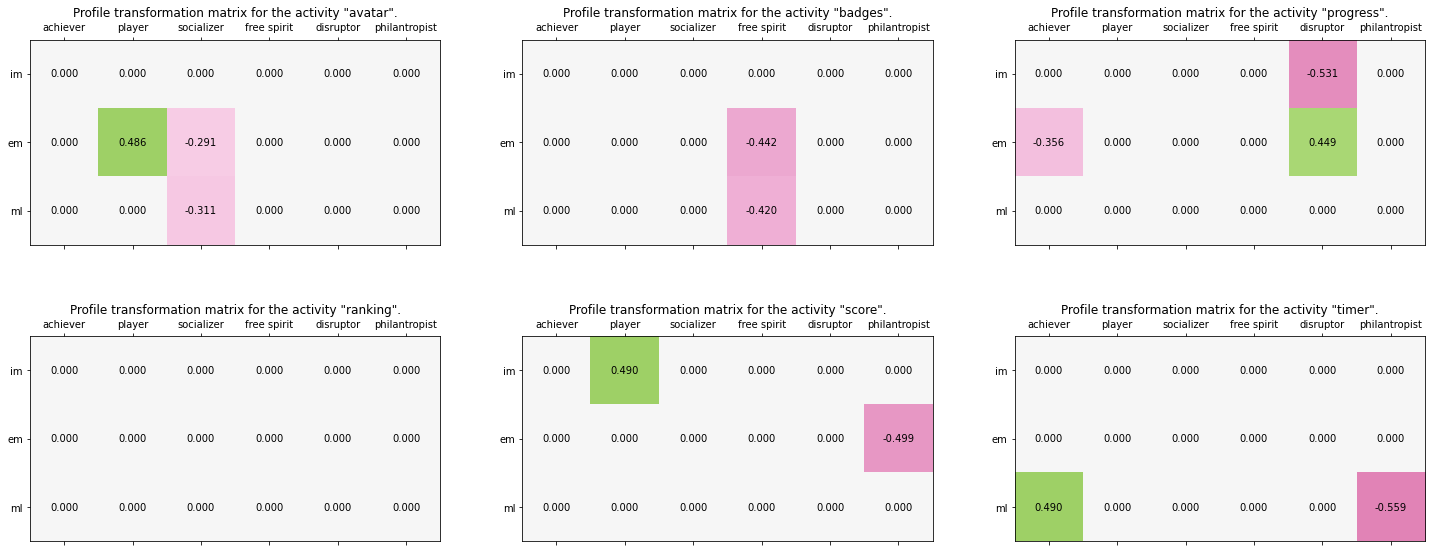

In [9]:
threshold = 0.1
hexad_transforms = {a: apply_mask(hexad_raw_transforms[a], 
                                  hexad_transforms_masks[a], 
                                  threshold) 
                    for a in activities}

        
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))

for i, (a, m) in enumerate(hexad_transforms.items()):
    ax = axes[(i//3), i%3]
    ax.set_title("Profile transformation matrix for the activity \"%s\"." % a)
    draw_matrix(ax, m, hexads, motivations_short)

#### Après avoir réhaussé le seuil à 0.1, on note les changements suivants:
 - (m1) Les profils plutôt "socializer" auront tendance à perdre en motivation externe ET en amotivation après une activitée à base d'"avatar".
 - (m2) Il en vas de même, dans une autre mesure, pour les profils plutôt "free spirit" après une activitée à base de "badges".
 - (m6) Les activitées à base de "timer" font maintenant gagner en amotivation (=mauvais) les profils à tendance "achiever".

### Analyse des transformations permettant d'obtenir un changement dans le profil de motivation en fonction d'un profil de motivation initial et d'une activité. 

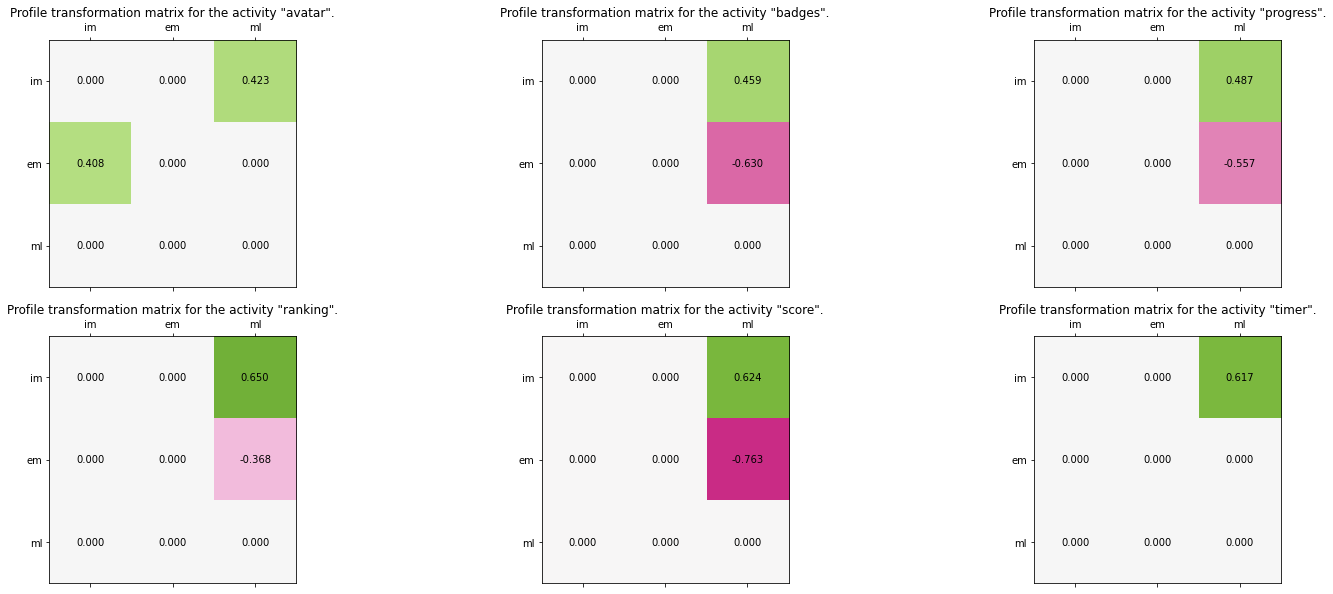

In [10]:
threshold = 0.05
motivation_transforms = {a: apply_mask(motivation_raw_transforms[a], 
                                       motivation_transforms_masks[a], 
                                       threshold) for a in activities}

        
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))

for i, (a, m) in enumerate(motivation_transforms.items()):
    ax = axes[(i//3), i%3]
    ax.set_title("Profile transformation matrix for the activity \"%s\"." % a)
    draw_matrix(ax, m, motivations_short, motivations_short)

#### Analyse avec un seuil de 0.05:
 - La première matrice de transformation nous informe que les utilisateurs à profil plutôt en perte de motivation("amotivation") auront tendance à gagner en motivation intrinsèque après une activité basée sur les "avatar". Les utilisateurs plutôt motivé intrinsèquement auront quant à eux, tendance à gagner en motivation externe.
 - Les matrices n°2 à n°5 nous informent que les utilisateurs à profil plutôt "amotivation", auront tendance à gagner en motivation intrinsèque et à perdre en motivation externe après une activitée basée sur une chacune catégories suivantes: "badges", "progress", "ranking", "score". Et ce, à dans des mesures respectivement distinctes.
 - La dernière nous informe que'un utilisateur au profil plutôt "amotivation" gagnera en motivation intrinsèque après une activitée à base de "timer".

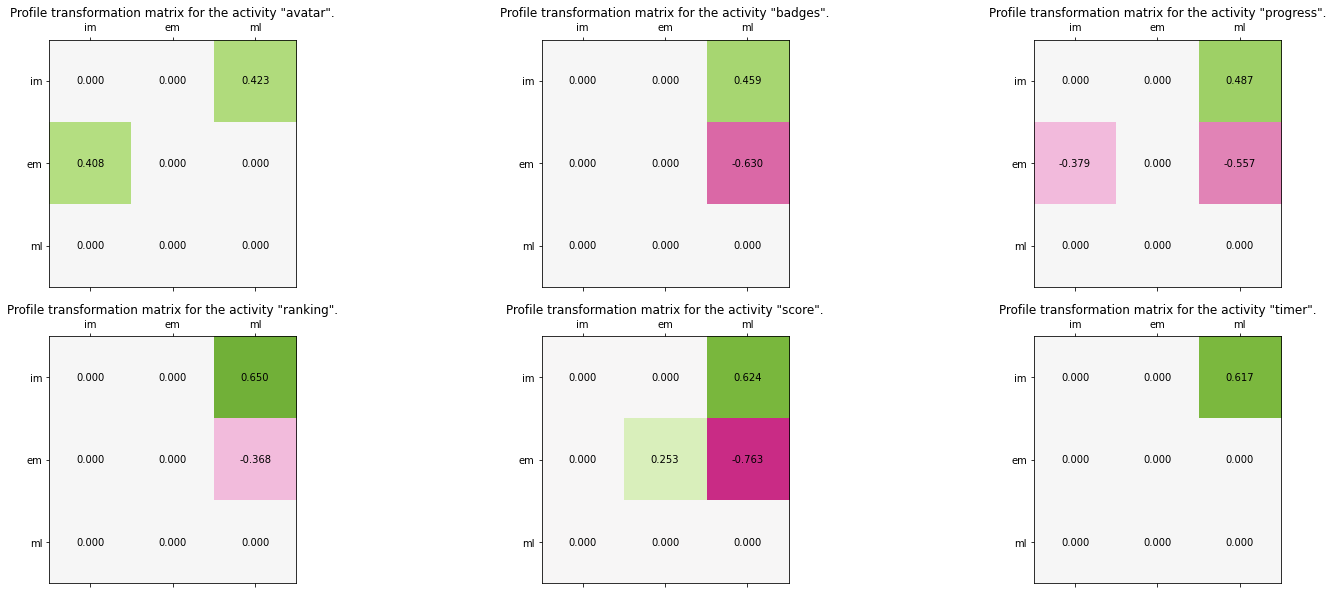

In [11]:
threshold = 0.1
motivation_transforms = {a: apply_mask(motivation_raw_transforms[a], 
                                       motivation_transforms_masks[a], 
                                       threshold) 
                         for a in activities}

        
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,10))

for i, (a, m) in enumerate(motivation_transforms.items()):
    ax = axes[(i//3), i%3]
    ax.set_title("Profile transformation matrix for the activity \"%s\"." % a)
    draw_matrix(ax, m, motivations_short, motivations_short)

#### Après avoir réhaussé le seuil à 0.1, on note les changements suivants:
 - (m3) Les profils à tendance intrinsèquement motivés ("im") auront tendront cette fois-ci à perdre en motivation externe après une activité à base de "progress".
 - (m5) Les profils à tendance motivés externe ("em") auront tendront cette fois-ci à gagner en motivation externe après une activité à base de "progress".

## Analyse des profils utilisateurs

In [12]:
hexad_profiles_array = np.array([p for p in hexad_profiles.values()])
hexad_avgs = [np.mean(hexad_profiles_array[:,i]) for i in range(len(hexads))]
hexad_std = [np.std(hexad_profiles_array[:,i]) for i in range(len(hexads))]

plt.bar(hexads, hexad_avgs, yerr=hexad_std, align='center', alpha=0.5, ecolor='black', capsize=10)

plt.show()

In [13]:
moti_profiles_array = np.array([p for p in motivation_profiles.values()])
moti_avgs = [np.mean(moti_profiles_array[:,i]) for i in range(len(motivations))]
moti_std = [np.std(moti_profiles_array[:,i]) for i in range(len(motivations))]

plt.bar(motivations, moti_avgs, yerr=moti_std, align='center', alpha=0.5, ecolor='black', capsize=10)

plt.show()

Nous observons que la motivation intrinsèque et la motivation externe dominent l'amotivation.
Au regard des A-Matrices correspondant aux transofrmations de profil de motivation, on remarque qu'il y a peu de cas où choisir autre chôse que "avatar" semble pertinent.

## Suggestion d'activités.

### Normalisation des profils (n'aura pas d'impact avant la partie 2)

In [14]:
hexad_profiles_norm = {i: p / np.linalg.norm(p) for i, p in hexad_profiles.items()}
motivation_profiles_norm = {i: p / np.linalg.norm(p) for i, p in motivation_profiles.items()}

### Heuristique
Nous cherchons à maximiser les deux premières composantes de motivation (mi et me) tout en minimisant la troisième (amot). Soit, un produit linéaire entre le vecteur ligne de motivation, et le vecteur colone [1, 1, -1]

In [15]:
def heuristic(motivation):
    return np.array([1, 1, -1]).dot(motivation)

### Suggestion hexad
Nous effectuons pour chaque combinaison élève / activité, une transformation de son profil hexad au travers de la matrice associée à l'activitée en question. Le seuil utilisé ici sera le même que celui de la dernière cellule affectant `hexad_transforms` (0.1 si le notebook est éxecuté dans l'ordre)

Nous cherchons ensuite, pour chaque élève, à quelle activité appartient la transformation qui à su tirer la meilleure position dans le co-domaine (changement de vecteur motivation) accordément à l'heuristique précédemment définie (vecteur d'affinité puis résolution argmax).

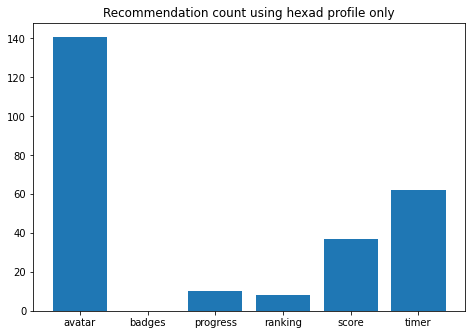

In [16]:
# Generate the affinity vector (to every activity) for each user hexad profile.
hexad_activity_affinity = {i: {a: heuristic(t.dot(p)) for a, t in hexad_transforms.items()} 
                           for i, p in hexad_profiles_norm.items()}
# For each user: ArgMax(activity -> heuristic(activityHexM * profileHex)).
hexad_activity_recommendation = {i: max(e.items(), key=operator.itemgetter(1))[0] 
                                 for i, e in hexad_activity_affinity.items()}

plot_recommendation_occurences(hexad_activity_recommendation, \
                               "Recommendation count using hexad profile only")  

In [17]:
for i, (u, r) in enumerate(hexad_activity_recommendation.items()):
    if i > 3:
        break
    print("%s is recommended %s according to it's hexad profile." % (u, r))
      
        
print("%s is recommended %s according to it's hexad profile." 
      % ("elevebf10", hexad_activity_recommendation["elevebf10"]))

elevebf01 is recommended avatar according to it's hexad profile.
elevebf03 is recommended avatar according to it's hexad profile.
elevebf04 is recommended score according to it's hexad profile.
elevebf05 is recommended timer according to it's hexad profile.
elevebf10 is recommended avatar according to it's hexad profile.


### Suggestion motivation.

De la même manière que dans la partie précédente, il nous est possible de maximiser une activité / transformation accordément à l'heuristique précédemment définie, mais cette fois-ci, avec un profil de motivation. Le seuil utilisé ici sera le même que celui de la dernière cellule affectant `hexad_transforms` (0.1 si le notebook est éxecuté dans l'ordre)

Afin de respecter les contraintes de transformation linéaires (domaine(3) -> co-domaine(3)) il nous faudra cette fois-ci utiliser les transformations 3*3 calculées à cet effet et que l'on à construit à pertir du répertoire "Motivation".

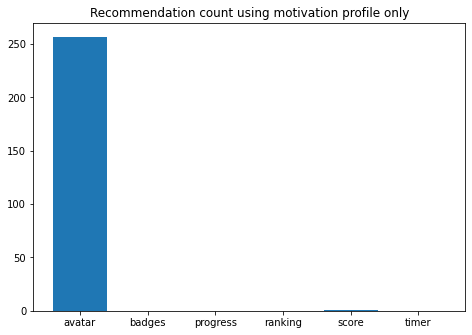

In [18]:
# Generate the affinity vector (to every activity) for each user motivation profile.
motivation_activity_affinity = {i: {a: heuristic(t.dot(p)) for a, t in motivation_transforms.items()} 
                                for i, p in motivation_profiles_norm.items()}
# For each user: ArgMax(activity -> heuristic(activityMotM * profileMot)).
motivation_activity_recommendation = {i: max(e.items(), key=operator.itemgetter(1))[0] 
                                      for i, e in motivation_activity_affinity.items()}

plot_recommendation_occurences(motivation_activity_recommendation, \
                               "Recommendation count using motivation profile only")

In [19]:
for i, (u, r) in enumerate(motivation_activity_recommendation.items()):
    if i > 3:
        break
    print("%s is recommended %s according to it's motivation profile." % (u, r))
    
        
print("%s is recommended %s according to it's motivation profile." 
      % ("elevebf10", hexad_activity_recommendation["elevebf10"]))

elevebf01 is recommended avatar according to it's motivation profile.
elevebf03 is recommended avatar according to it's motivation profile.
elevebf04 is recommended avatar according to it's motivation profile.
elevebf05 is recommended avatar according to it's motivation profile.
elevebf10 is recommended avatar according to it's motivation profile.


## Combinaison des deux profils / transformations pour générer une proposition unique.
Afin de pouvoir profiter des informations contenues dans l'analyse des deux profils / domaines (hexad et motivation). Nous avons pensé à 2 solutions:
 - La première consisterait à utiliser comme paramètre de l'heuristique la moyenne des positions dans le co-domaine des deux transformations de chaque activités.
 - La seconde consisterait à utiliser le vecteur d'affinité moyen des deux méthodes afin d'obtenir un seul vecteur à maximiser.
 
Du fait que le co-domaine est le même pour les deux profils, et que l'heuristique est un produit linéaire d'une position dans ce dernier, ces deux approches sont sémentiquement équivalentes.

Ayant calculé préalablement (pour la partie précédente) le vecteur d'affinité associé a chaque profil, nous utiliserons la seconde dans la pratique.

In [20]:
def compound_affinity_generator(affinity_a, affinity_b, ratio = 0.5):
    return {a: (affinity_a[a] * (1-ratio) + affinity_b[a] * ratio) for a in affinity_a.keys()}

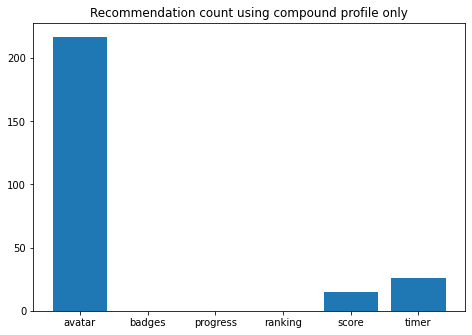

In [21]:
# Generate the affinity vector (to every activity) as the average 
# of the two previously computed affinity vectors
# (from hexad profile, and from motivation profile).
compound_activity_affinity = {i: compound_affinity_generator(hexad_activity_affinity[i], 
                                                             motivation_activity_affinity[i], 0.5)
                              for i in hexad_activity_affinity.keys()}

# For each user: ArgMax(activity -> (heuristic(activityHexM * profileHex) 
#                                    + heuristic(activityMotM * profileMot)) / 2).
compound_activity_recommendation = {i: max(e.items(), key=operator.itemgetter(1))[0] 
                                    for i, e in compound_activity_affinity.items()}

plot_recommendation_occurences(compound_activity_recommendation, \
                               "Recommendation count using compound profile only")


In [22]:
for i, (u, r) in enumerate(compound_activity_recommendation.items()):
    if i > 3:
        break
    print("%s is recommended %s according to it's compound profile." % (u, r))
    
        
print("%s is recommended %s according to it's compound profile." 
      % ("elevebf10", compound_activity_recommendation["elevebf10"]))

elevebf01 is recommended avatar according to it's compound profile.
elevebf03 is recommended avatar according to it's compound profile.
elevebf04 is recommended score according to it's compound profile.
elevebf05 is recommended avatar according to it's compound profile.
elevebf10 is recommended avatar according to it's compound profile.


En utilisant cette méthode, nous remarquons que la méthode par profil de motivation influe beaucoup sur le résultat.